## Ciência de Dados em Larga Escala  
### Trabalho Prático - Performance Analysis  
## Bruno Costa e José Santos
# Grupo Z

###  Visão Geral  

Este notebook foca na tarefa de machine learning para prever o valor da tarifa (`fare_amount`) no dataset de táxi, utilizando dois modelos diferentes:

### Modelos de Machine Learning Utilizados:

**XGBRegressor:**  
- Modelo de regressão baseado em árvores de decisão do framework XGBoost.  
- Destaca-se pela alta performance, capacidade de lidar com dados complexos, regularização para evitar overfitting e suporte a paralelismo para acelerar o treinamento.  
- Produz previsões contínuas para o valor da tarifa.

**LogisticRegression:**  
- Modelo de classificação que estima a probabilidade de uma amostra pertencer a uma classe específica.  
- Para essa tarefa, a variável `fare_amount` é convertida em categorias discretas.  
- Fácil de implementar, interpretável e com baixo custo computacional.  
- Classifica a tarifa em 4 categorias distintas.

### Processo Realizado:  
Foi construída uma pipeline de ML que inclui leitura dos dados, pré-processamento, treino, validação, teste e avaliação de métricas.  

O processo foi executado para ambos os modelos, inicialmente utilizando uma amostra com dados do primeiro mês de 2009 (1 arquivo) e depois uma amostra maior com os dois primeiros meses de 2009 (2 arquivos), para avaliar a robustez dos modelos.


In [10]:
import pandas as pd
df = pd.read_parquet('Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet')

In [11]:
df

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt
0,VTS,2009-12-17 07:35:00,2009-12-17 07:40:00,1,0.11,-73.987928,40.737885,NaN,NaN,-73.990335,40.748450,Credit,4.9,0.0,0.5,1.0,0.0,6.4
1,VTS,2009-12-21 14:19:00,2009-12-21 14:24:00,1,1.07,-73.956008,40.779558,NaN,NaN,-73.967303,40.787833,CASH,4.9,0.0,0.5,0.0,0.0,5.4
2,VTS,2009-12-18 03:09:00,2009-12-18 03:34:00,1,8.98,-73.955745,40.689503,NaN,NaN,-73.937730,40.737463,CASH,23.7,0.5,0.5,0.0,0.0,24.7
3,VTS,2009-12-14 21:24:00,2009-12-14 21:33:00,2,1.66,-73.983985,40.754645,NaN,NaN,-73.986195,40.737610,Credit,6.9,0.5,0.5,3.0,0.0,10.9
4,VTS,2009-12-18 08:17:00,2009-12-18 08:29:00,1,1.55,-73.959132,40.769265,NaN,NaN,-73.976267,40.760615,CASH,7.7,0.0,0.5,0.0,0.0,8.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14583399,VTS,2009-12-26 14:06:00,2009-12-26 14:13:00,1,0.95,-73.979943,40.775545,NaN,NaN,-73.979182,40.765658,CASH,5.7,0.0,0.5,0.0,0.0,6.2
14583400,VTS,2009-12-26 21:40:00,2009-12-26 21:59:00,5,6.97,-74.017145,40.705885,NaN,NaN,-73.971427,40.782797,CASH,18.5,0.5,0.5,0.0,0.0,19.5
14583401,VTS,2009-12-05 11:13:00,2009-12-05 11:16:00,1,0.88,-73.975970,40.752222,NaN,NaN,-73.966812,40.763617,CASH,4.5,0.0,0.5,0.0,0.0,5.0
14583402,VTS,2009-12-26 18:48:00,2009-12-26 18:52:00,5,0.65,-73.955460,40.779757,NaN,NaN,-73.950940,40.775177,CASH,4.5,0.0,0.5,0.0,0.0,5.0


# ML pipeline para 1 ficheiro

# ML XGBRegressor

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [13]:
def extract_datetime_features(df, col):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_hour'] = df[col].dt.hour
        df.drop(columns=[col], inplace=True)
    return df

# Passo 1: Leitura dos dados

In [14]:
file_path = 'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet'
data = pd.read_parquet(file_path)
data = data.rename(columns=str.lower)
print("Colunas do DataFrame:", data.columns)
print("Primeiras linhas do DataFrame:", data.head())

Colunas do DataFrame: Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')
Primeiras linhas do DataFrame:   vendor_name trip_pickup_datetime trip_dropoff_datetime  passenger_count  \
0         VTS  2009-12-17 07:35:00   2009-12-17 07:40:00                1   
1         VTS  2009-12-21 14:19:00   2009-12-21 14:24:00                1   
2         VTS  2009-12-18 03:09:00   2009-12-18 03:34:00                1   
3         VTS  2009-12-14 21:24:00   2009-12-14 21:33:00                2   
4         VTS  2009-12-18 08:17:00   2009-12-18 08:29:00                1   

   trip_distance  start_lon  start_lat  rate_code  store_and_forward  \
0           0.11 -73.987928  40.737885        NaN                NaN   
1          

# Passo 2: Pré-processamento

O código realiza o pré-processamento dos dados do primeiro arquivo para preparar a modelagem de machine learning, seguindo estes passos:

- **Identificação de valores ausentes:** Detecta e lista as colunas que possuem valores nulos.  
- **Remoção de colunas com muitos nulos:** Exclui as colunas que têm mais de 50% dos dados faltantes.  
- **Extração de características temporais:** Cria novas variáveis a partir das colunas de data e hora (`trip_pickup_datetime` e `trip_dropoff_datetime`).  
- **Preenchimento de dados faltantes:** Nas colunas numéricas restantes, substitui os valores nulos pela média da coluna.  
- **Remoção de colunas categóricas:** Elimina colunas categóricas como `fare_amt`, `vendor_name`, `payment_type` e, se existir, `store_and_forward`.  
- **Definição das variáveis para o modelo:** Define `X` como os dados restantes (sem as colunas removidas) e `y` como a variável alvo `fare_amt`.  

Caso a coluna `fare_amt` não esteja presente, o código lança um erro do tipo KeyError.


In [15]:
if 'fare_amt' in data.columns:
    null_columns = data.columns[data.isnull().any()]
    print("Colunas:", null_columns)
    half_count = len(data) / 2
    data = data.dropna(thresh=half_count, axis=1)
    data = extract_datetime_features(data, 'trip_pickup_datetime')
    data = extract_datetime_features(data, 'trip_dropoff_datetime')
    for col in data.columns:
        if data[col].isnull().any():
            if data[col].dtype in ['float64', 'int64']:
                data[col].fillna(data[col].mean(), inplace=True)
    print("Número de linhas:", len(data))
    columns_to_drop = ['fare_amt', 'vendor_name', 'payment_type']
    if 'store_and_forward' in data.columns:
        columns_to_drop.append('store_and_forward')
    X = data.drop(columns=columns_to_drop)
    y = data['fare_amt']
else:
    raise KeyError("'fare_amt' not found in columns")

Colunas: Index(['rate_code', 'store_and_forward', 'mta_tax'], dtype='object')


/var/tmp/ipykernel_13781/972569988.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


Número de linhas: 14583404


In [16]:
if len(X) == 0 or len(y) == 0:
    raise ValueError("O DataFrame está vazio.")

In [17]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Colunas numéricas:", numeric_features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ])

Colunas numéricas: ['passenger_count', 'trip_distance', 'start_lon', 'start_lat', 'end_lon', 'end_lat', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt', 'total_amt']


**Passo 3: Construção da pipeline de pré-processamento e modelo de ML**

- **Pipeline:** Monta uma sequência de etapas que inclui:
  - **Padronização:** Normaliza as variáveis numéricas usando `StandardScaler`.
  - **Modelo:** Utiliza o `XGBRegressor` com hiperparâmetros definidos:
    - número de estimadores: 100
    - taxa de aprendizado: 0.1
    - profundidade máxima: 5
    - amostragem subsample: 0.8
    - amostragem por árvore (colsample_bytree): 0.8
    - semente aleatória (random_state): 42


In [18]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('xgb', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))  
])

**Passo 4: Divisão dos dados em treino e teste**

- Divide os dados usando `train_test_split`, separando 20% para teste.
- Define `random_state=42` para garantir resultados reproduzíveis.
- Exibe as primeiras linhas dos conjuntos de treino (`X_train`) e teste (`X_test`) para conferência.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Verificar as primeiras linhas dos conjuntos de treino
print("Linhas de treinamento (X_train):")
print(X_train.head())
print("Linhas de teste (X_test):")
print(X_test.head())

Linhas de treinamento (X_train):
          passenger_count  trip_distance  start_lon  start_lat    end_lon  \
12571585                1           3.60 -73.980488  40.785387 -73.985295   
8970059                 1           1.20 -73.952426  40.776909 -73.958940   
13893616                2           0.91 -73.968558  40.763205 -73.961493   
11346326                1           1.90 -74.004854  40.723294 -73.987583   
12127814                1           1.90 -73.992683  40.729915 -74.007945   

            end_lat  surcharge   mta_tax  tip_amt  tolls_amt  total_amt  \
12571585  40.745694        0.0  0.500000      0.0        0.0       11.4   
8970059   40.767384        0.0  0.498024      1.6        0.0        9.8   
13893616  40.774097        1.0  0.500000      0.0        0.0        6.0   
11346326  40.743186        0.0  0.500000      0.0        0.0        7.4   
12127814  40.709607        0.5  0.500000      3.0        0.0       10.9   

          trip_pickup_datetime_year  trip_pickup_date

In [20]:
preprocessed_X_train = preprocessor.fit_transform(X_train)
print(preprocessed_X_train.shape)

(11666723, 11)


# Passo 5: treino do modelo

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

# Passo 6: teste

In [22]:
y_pred = pipeline.predict(X_test)

# Passo 7: Métricas de avaliação

In [14]:
from sklearn.model_selection import cross_val_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-cv_scores.mean()}")

Mean Squared Error: 0.9901418510565
Mean Absolute Error: 0.151859538879326
R-squared: 0.9838649053609924
Cross-Validation MSE: 0.976687436973662


In [15]:
import numpy as np
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}%")

Root Mean Squared Error: 0.9950587173913407
Mean Absolute Percentage Error: 1.2987277781112836%


In [16]:
def accuracy_within_margin(y_true, y_pred, margin=0.1):
    within_margin = np.abs((y_true - y_pred) / y_true) < margin
    return np.mean(within_margin)
accuracy_10_percent = accuracy_within_margin(y_test, y_pred, margin=0.1)
print(f"Previsões dentro de 10% de erro: {accuracy_10_percent * 100:.2f}%")

Previsões dentro de 10% de erro: 99.61%


**Métricas de Erro**

- **Mean Squared Error (MSE):** Mede a média dos quadrados dos erros, penalizando mais os erros maiores. Valores menores indicam melhor desempenho.
- **Mean Absolute Error (MAE):** Calcula a média dos erros absolutos, mostrando quão próximas as previsões estão dos valores reais. Valores menores são melhores.
- **R-squared:** Indica a proporção da variabilidade dos dados explicada pelo modelo. Valores próximos de 1 indicam bom ajuste.
- **Root Mean Squared Error (RMSE):** Raiz quadrada do MSE, com unidade igual à da variável alvo. Valores menores indicam melhor desempenho.
- **Mean Absolute Percentage Error (MAPE):** Mede a média percentual dos erros absolutos. Valores menores indicam maior precisão percentual.

**Validação Cruzada**

- Avaliação robusta usando múltiplas divisões dos dados. Resultados consistentes indicam que o modelo não está sobreajustado.

**Métrica Customizada**

- Percentual de previsões dentro de uma margem de erro aceitável. Valores altos indicam que a maioria das previsões está muito próxima dos valores reais.

**Análise Geral**

- As métricas indicam que o modelo apresenta boa performance, com erros pequenos e alta explicação da variabilidade dos dados.
- A validação cruzada reforça a consistência do modelo, evitando overfitting.
- A métrica customizada confirma alta precisão das previsões, sugerindo que o modelo está bem ajustado para o dataset.


# Concluímos que que a feature mais importante é: total_amt

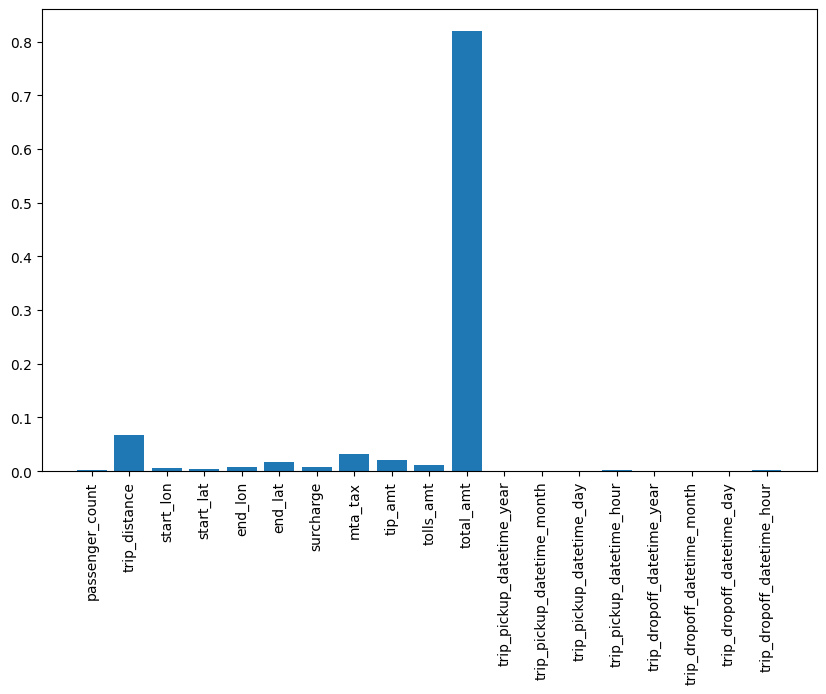

In [17]:
import matplotlib.pyplot as plt
importance = pipeline.named_steps['xgb'].feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(X.columns, importance)
plt.xticks(rotation=90)
plt.show()

# LogisticRegression

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

**Pré-processamento**

- **Tratamento de Valores Nulos:** Identifica colunas com valores ausentes, remove aquelas com mais de 50% de dados faltantes e preenche os valores nulos restantes nas colunas numéricas com a média.
- **Extração de Datas e Horas:** Cria novas características a partir das colunas de data e hora.
- **Discretização da Variável Alvo:** Converte a variável alvo 'fare_amt' em categorias usando uma divisão em quatro faixas.
- **Remoção de Colunas Categóricas:** Exclui as colunas categóricas vendor_name, payment_type e fare_amt, além da coluna store_and_forward caso exista.
- **Definição das Variáveis:** Define X com os dados restantes após remoções e y como a variável alvo discretizada. Caso a coluna alvo não esteja presente, ocorre um erro.


In [23]:
if 'fare_amt' in data.columns:
    null_columns = data.columns[data.isnull().any()]
    print("Colunas com valores nulos:", null_columns)
    half_count = len(data) / 2
    data = data.dropna(thresh=half_count, axis=1)
    data = extract_datetime_features(data, 'trip_pickup_datetime')
    data = extract_datetime_features(data, 'trip_dropoff_datetime')
    for col in data.columns:
        if data[col].isnull().any():
            if data[col].dtype in ['float64', 'int64']:
                data[col].fillna(data[col].mean(), inplace=True)

    print("Número de linhas:", len(data))
    data['fare_amt_bins'] = pd.qcut(data['fare_amt'], q=4, labels=False, duplicates='drop')
    columns_to_drop = ['vendor_name', 'payment_type', 'fare_amt', 'fare_amt_bins']
    if 'store_and_forward' in data.columns:
        columns_to_drop.append('store_and_forward')
    y = data['fare_amt_bins']
    X = data.drop(columns=['vendor_name', 'payment_type', 'fare_amt', 'store_and_forward', 'fare_amt_bins'], errors='ignore')
else:
    raise KeyError("'fare_amt' not found in columns")

Colunas com valores nulos: Index([], dtype='object')
Número de linhas: 14583404


In [24]:
if len(X) == 0 or len(y) == 0:
    raise ValueError("O DataFrame vazio.")
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Colunas:", numeric_features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ])

Colunas: ['passenger_count', 'trip_distance', 'start_lon', 'start_lat', 'end_lon', 'end_lat', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt', 'total_amt']


# Pipeline 

In [25]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Divisão dos Dados

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Linhas de treino (X_train):")
print(X_train.head())
print("Linhas de teste (X_test):")
print(X_test.head())

Linhas de treino (X_train):
          passenger_count  trip_distance  start_lon  start_lat    end_lon  \
12571585                1           3.60 -73.980488  40.785387 -73.985295   
8970059                 1           1.20 -73.952426  40.776909 -73.958940   
13893616                2           0.91 -73.968558  40.763205 -73.961493   
11346326                1           1.90 -74.004854  40.723294 -73.987583   
12127814                1           1.90 -73.992683  40.729915 -74.007945   

            end_lat  surcharge   mta_tax  tip_amt  tolls_amt  total_amt  \
12571585  40.745694        0.0  0.500000      0.0        0.0       11.4   
8970059   40.767384        0.0  0.498024      1.6        0.0        9.8   
13893616  40.774097        1.0  0.500000      0.0        0.0        6.0   
11346326  40.743186        0.0  0.500000      0.0        0.0        7.4   
12127814  40.709607        0.5  0.500000      3.0        0.0       10.9   

          trip_pickup_datetime_year  trip_pickup_datetime_

# Treino do Modelo

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['passenger_count',
                                                   'trip_distance', 'start_lon',
                                                   'start_lat', 'end_lon',
                                                   'end_lat', 'surcharge',
                                                   'mta_tax', 'tip_amt',
                                                   'tolls_amt',
                                                   'total_amt'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [24]:
y_pred = pipeline.predict(X_test)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9986470923628604
Precision: 0.9986478102461129
Recall: 0.9986470923628604
F1 Score: 0.9986469974401552


### Análise dos Resultados

- **Acurácia:** Mede a proporção de previsões corretas em relação ao total, indicando um desempenho muito bom do modelo.  
- **Precisão:** Avalia quantas das previsões positivas são realmente corretas, importante para evitar falsos positivos.  
- **Recall:** Indica a capacidade do modelo de identificar as amostras positivas, essencial para minimizar falsos negativos.  
- **F1 Score:** Combina precisão e recall, mostrando um bom equilíbrio entre os dois.

**Conclusão:**  
O modelo apresenta um desempenho excelente, com métricas muito altas, resultado da qualidade dos dados, do modelo robusto utilizado e da boa escolha dos parâmetros.


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Análise da Matriz de Confusão

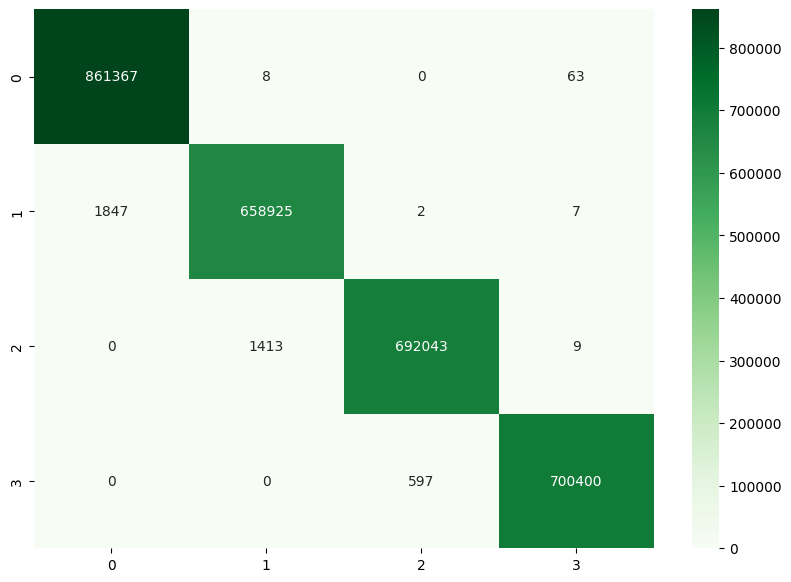

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.show()

### Conclusão

- O modelo classifica a maioria dos dados corretamente, com poucas confusões entre classes próximas.  
- O gráfico destaca quais variáveis mais influenciam as previsões, mostrando sua importância no modelo.


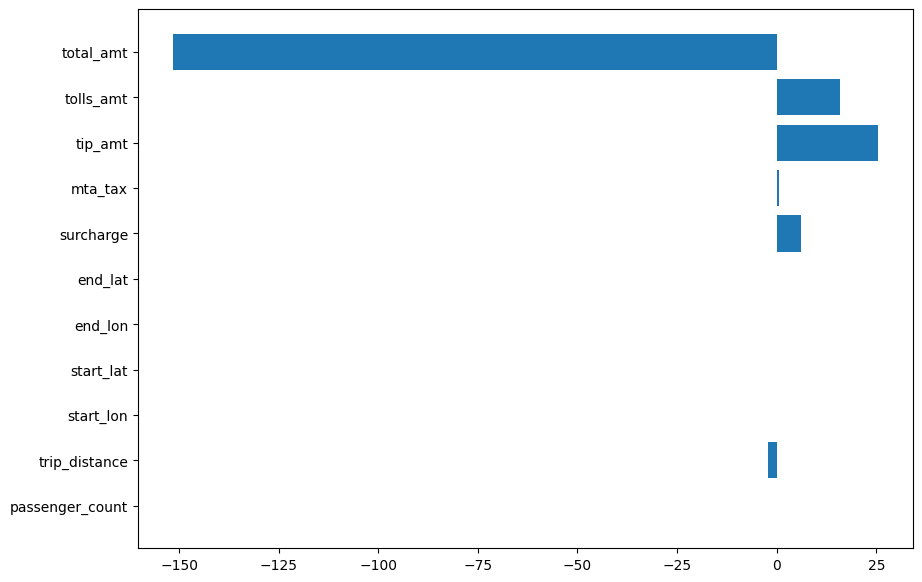

In [28]:
if hasattr(pipeline.named_steps['classifier'], 'coef_'):
    importances = pipeline.named_steps['classifier'].coef_[0]
    feature_names = numeric_features
    plt.figure(figsize=(10, 7))
    plt.barh(feature_names, importances)
    plt.show()

### Análise das Variáveis Mais Importantes

- **total_amt** é a variável que mais impacta o modelo, com forte efeito positivo na previsão.  
- **tip_amt** e **tolls_amt** também influenciam positivamente, mas em menor intensidade.  
- Variáveis de localização (latitude, longitude) e data/hora têm pouca influência, com coeficientes próximos de zero.  

**Conclusão:**  
O valor total da tarifa é o principal fator para as previsões, enquanto gorjetas e pedágios têm impacto moderado. Informações de tempo e localização pouco afetam o resultado.


# Procedimento para os dois meses

# XGBRegressor

In [4]:
file_paths = ['Ficheiros/taxi_csv/yellow_tripdata_2009-11.parquet', 'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet']
data_list = [pd.read_parquet(file_path).rename(columns=str.lower) for file_path in file_paths]
data = pd.concat(data_list, ignore_index=True)
print("Colunas do DataFrame:", data.columns)
print("Linhas do DataFrame:", data.head())

Colunas do DataFrame: Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')
Linhas do DataFrame:   vendor_name trip_pickup_datetime trip_dropoff_datetime  passenger_count  \
0         VTS  2009-11-23 16:19:00   2009-11-23 16:23:00                1   
1         VTS  2009-11-05 16:48:00   2009-11-05 16:56:00                5   
2         VTS  2009-11-17 08:24:00   2009-11-17 08:31:00                1   
3         VTS  2009-11-01 14:34:00   2009-11-01 14:39:00                1   
4         VTS  2009-11-17 13:49:00   2009-11-17 13:57:00                1   

   trip_distance  start_lon  start_lat  rate_code  store_and_forward  \
0           0.76 -73.975327  40.751015        NaN                NaN   
1           1.60 -73.

In [9]:
if 'fare_amt' in data.columns:
    null_columns = data.columns[data.isnull().any()]
    print("Colunas com valores nulos:", null_columns)
    half_count = len(data) / 2
    data = data.dropna(thresh=half_count, axis=1)
    data = extract_datetime_features(data, 'trip_pickup_datetime')
    data = extract_datetime_features(data, 'trip_dropoff_datetime')
    for col in data.columns:
        if data[col].isnull().any():
            if data[col].dtype in ['float64', 'int64']:
                data[col].fillna(data[col].mean(), inplace=True)
    print("Número de Linhas:", len(data))
    columns_to_drop = ['fare_amt', 'vendor_name', 'payment_type']
    if 'store_and_forward' in data.columns:
        columns_to_drop.append('store_and_forward')
    X = data.drop(columns=columns_to_drop)
    y = data['fare_amt']
else:
    raise KeyError("'fare_amt' not found in columns")
if len(X) == 0 or len(y) == 0:
    raise ValueError("O DataFrame está vazio.")
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Colunas numéricas:", numeric_features)

Colunas com valores nulos: Index(['mta_tax'], dtype='object')


/var/tmp/ipykernel_12563/547233120.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


Número de Linhas: 28858743
Colunas numéricas: ['passenger_count', 'trip_distance', 'start_lon', 'start_lat', 'end_lon', 'end_lat', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt', 'total_amt']


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ])

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )) 
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Linhas de treinamento:")
print(X_train.head())
print("Linhas de teste:")
print(X_test.head())
preprocessed_X_train = preprocessor.fit_transform(X_train)
print(preprocessed_X_train.shape)

Linhas de treinamento:
          passenger_count  trip_distance  start_lon  start_lat    end_lon  \
3986899                 1           1.25 -73.977625  40.742068 -73.995705   
6268905                 1           1.00 -73.951600  40.775300 -73.964096   
15221344                1           1.49 -73.992885  40.742882 -73.977368   
19569835                2           5.10 -73.989090  40.721464 -73.977844   
19424061                3           0.70 -73.991712  40.744347 -73.991199   

            end_lat  surcharge  mta_tax  tip_amt  tolls_amt  total_amt  \
3986899   40.742487        0.0      0.5      0.0        0.0        6.6   
6268905   40.770525        0.5      0.5      0.0        0.0        6.3   
15221344  40.756913        0.0      0.5      0.0        0.0        9.4   
19569835  40.777046        0.0      0.5      0.0        0.0       16.6   
19424061  40.735913        0.0      0.5      0.0        0.0        5.8   

          trip_pickup_datetime_year  trip_pickup_datetime_month  \
39

In [11]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-cv_scores.mean()}")

Mean Squared Error: 0.9283375152617245
Mean Absolute Error: 0.15348584230639453
R-squared: 0.9848290602096089


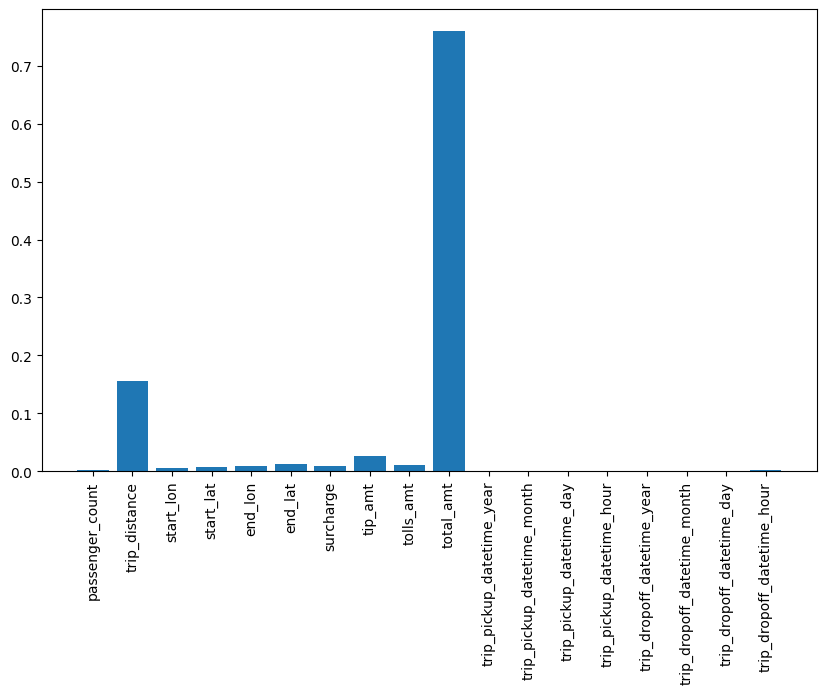

In [34]:
importance = pipeline.named_steps['xgb'].feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(X.columns, importance)
plt.xticks(rotation=90)
plt.show()

# LogisticRegression

In [27]:
if 'fare_amt' in data.columns:
    null_columns = data.columns[data.isnull().any()]
    print("Colunas com valores nulos:", null_columns)
    half_count = len(data) / 2
    data = data.dropna(thresh=half_count, axis=1)
    data = extract_datetime_features(data, 'trip_pickup_datetime')
    data = extract_datetime_features(data, 'trip_dropoff_datetime')
    for col in data.columns:
        if data[col].isnull().any():
            if data[col].dtype in ['float64', 'int64']:
                data[col].fillna(data[col].mean(), inplace=True)

    print("Número de linhas após tratamento de nulos:", len(data))
    data['fare_amt_bins'] = pd.qcut(data['fare_amt'], q=4, labels=False, duplicates='drop')
    columns_to_drop = ['vendor_name', 'payment_type', 'fare_amt', 'fare_amt_bins']
    if 'store_and_forward' in data.columns:
        columns_to_drop.append('store_and_forward')
        y = data['fare_amt_bins']
    X = data.drop(columns=['vendor_name', 'payment_type', 'fare_amt', 'store_and_forward', 'fare_amt_bins'], errors='ignore')
else:
    raise KeyError("'fare_amt' not found in columns")

if len(X) == 0 or len(y) == 0:
    raise ValueError("O DataFrame está vazio.")
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Colunas numéricas:", numeric_features)

Colunas com valores nulos: Index([], dtype='object')
Número de linhas após tratamento de nulos: 14583404
Colunas numéricas: ['passenger_count', 'trip_distance', 'start_lon', 'start_lat', 'end_lon', 'end_lat', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt', 'total_amt']


In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Linhas de treino (X_train):")
print(X_train.head())
print("Linhas de teste (X_test):")
print(X_test.head())

Linhas de treino (X_train):
          passenger_count  trip_distance  start_lon  start_lat    end_lon  \
12571585                1           3.60 -73.980488  40.785387 -73.985295   
8970059                 1           1.20 -73.952426  40.776909 -73.958940   
13893616                2           0.91 -73.968558  40.763205 -73.961493   
11346326                1           1.90 -74.004854  40.723294 -73.987583   
12127814                1           1.90 -73.992683  40.729915 -74.007945   

            end_lat  surcharge   mta_tax  tip_amt  tolls_amt  total_amt  \
12571585  40.745694        0.0  0.500000      0.0        0.0       11.4   
8970059   40.767384        0.0  0.498024      1.6        0.0        9.8   
13893616  40.774097        1.0  0.500000      0.0        0.0        6.0   
11346326  40.743186        0.0  0.500000      0.0        0.0        7.4   
12127814  40.709607        0.5  0.500000      3.0        0.0       10.9   

          trip_pickup_datetime_year  trip_pickup_datetime_